# Toy Model
## 3nd Version, implementing model comparison

#ToDo:
- implement easy way to run build model of varying complexity and fit those for comparison
- split up forcing, so that pre-regime shift forcing is used only 
    - compare data, analysze pre-regime shift vs. after regime shift! what are the main differences?
- put model into OOP framework, build as package

# idea:
- phytoplankton class, that can be initialized to different functional groups
> diatom = phytoplankton(sizemean = 10, sizevar = 10, useN = 1, useSil = 1)
> nano = phytoplankton (sizemean = 2, sizevar = 2, useN = 1, useSil = 0) 

- main difference between functional groups are parameters

for zooplankton:
- again main difference are parameters (can implement different grazing functions, but always the same for both sizes)

# but let's get real!
# TODO:
- implement phytoplankton class with just 2 subclasses
- implement zooplankton class with just 2 subclasses
- adapt model code to call just these 2 or 1 of each

- run fitting algorithms for comparison

# initialisation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
# ExtractEnvFor:
import scipy.interpolate as intrp
import matplotlib as mpl
import time
import pandas
# Fitting
from lmfit import minimize, Parameters, Parameter, report_fit

# Interpolation and setting up EnvForcing

In [2]:
# functions adapted from PhytoSFDM Model by Esteban Acevedo-Trejos
def firstderivspl(Forcing, time, k=3, s=None):
    """
    Method to calculate the first derivative of an interpolated spline.

    Parameters
    ----------
    time: in days
    kind: the type of interpolation either linear, cubic, spline or
           piecewise polynomial
    k: Degree of the smoothing spline
    s: Positive smoothing factor used to choose the number of knots

    Returns
    -------
    The first derivative of the temporally interpolated environmental forcing spline.
    """
    outForcing = Forcing  # spatialave(Forcing)
    tmonth = np.linspace(0., 365., 13) #HERE deprecation warning due to 13. <- float, should be int
    newt = np.mod(time, 365.)
    outintp = intrp.UnivariateSpline(tmonth, outForcing, k=k, s=s)
    return outintp.derivative()(newt)

def dailyinterp(Forcing, time, kind='spline', k=3, s=None):
    """
    Method to interpolate from monthly to daily environmental data.

    Parameters
    -----
    time: in days
    kind: the type of interpolation either linear, cubic, spline or piecewise polynomial
    k: Degree of the smoothing spline
    s: Positive smoothing factor used to choose the number of knots

    Returns
    -------
    The temporally interpolated environmental forcing.
    """
    outForcing = Forcing  # spatialave(Forcing)

    tmonth = np.linspace(0., 12., 13) #HERE again, deprecation warning
    newt = np.mod(time, 365.) * 12. / 365.
    if kind == 'spline':
        outintp = intrp.UnivariateSpline(tmonth, outForcing, k=k, s=s)
        return outintp(newt)
    elif kind == 'PWPoly':
        outintp = intrp.PchipInterpolator(tmonth, outForcing)
        return outintp(newt)
    else:
        outintp = intrp.interp1d(tmonth, outForcing, kind=kind)
        return outintp(newt)

In [3]:
# parameters for interpolation
kmld = 3
smld = 0
kindmld = "spline"
kn0x = 5
sn0x = None
kindn0x = "spline"
kpar = 5
spar = None
kindpar = "spline"
ksst = 5
ssst = None
kindsst = "spline"
ksi0x = 5
ssi0x = None
kindsi0x = "spline"

In [4]:
# read environmental forcings
MLDfile = pandas.read_csv('CARIACO_forcing01/MLD')
MLD = list(MLDfile['press'])
MLD.append(MLDfile['press'][0])

NOXfile = pandas.read_csv('CARIACO_forcing01/N0')
NOX = list(NOXfile['as.numeric(NO3_NO2)'])
NOX.append(NOXfile['as.numeric(NO3_NO2)'][0])

SiOXfile = pandas.read_csv('CARIACO_forcing01/Si0')
SiOX = list(SiOXfile['as.numeric(Silicate)'])
SiOX.append(SiOXfile['as.numeric(Silicate)'][0])

SSTfile = pandas.read_csv('CARIACO_forcing01/SST')
SST = list(SSTfile['temp'])
SST.append(SSTfile['temp'][0])

PARfile = pandas.read_csv('CARIACO_forcing01/PAR')
PAR = list(PARfile['value'])
PAR.append(PARfile['value'][0])

In [5]:
# make all plots larger and more visible on dark background:
plt.rcParams['figure.figsize'] = [7, 6]
plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'})

plt.rcParams['figure.dpi']= 300


# Actual Model
  
## first define auxiliary functions for dealing with Parameters dict (lmfit)

In [6]:
def sliceparams(pardict, parprefix):
    """Function to extract functioanl type parameters from Parameters object, 
    using prefix in key"""
    return {k:v.value for k,v in pardict.items() if k.startswith(parprefix)}

def sliceoffparams(pardict, parprefix):
    """Function to remove e.g. functioanl type parameters from Parameters object, 
    using prefix in key"""
    return {k:v.value for k,v in pardict.items() if not k.startswith(parprefix)}

def extractparam(pardict, parsuffix):
    """Function to extract certain single parameter from sliced (!) Parameters object, 
    using final characters of key"""
    return next(v for k,v in pardict.items() if k.endswith(parsuffix))

def checkreplaceparam(stdpardict, functypepardict, parsuffix):
    """Function to check that certain single parameter from sliced (!) Parameters object, 
    using final characters of key"""
    try:
        ftpara = next(v for k,v in functypepardict.items() if k.endswith(parsuffix))
        return ftpara
    except StopIteration:
        return next(v for k,v in stdpardict.items() if k.endswith(parsuffix))
    


## functions to handle multiple type interaction (grazing)

In [7]:
# FUNCTIONS to handle multiple type grazing 
# (perhaps implement this within classes, for now outside)

def feedingmatrix(P,Z, pn,zn):
    l = [[phy,zoo] for phy in range(pn) for zoo in range(zn)]
    return l
    
def grazing(P,Z, pn,zn, zclass):
    l = [[phy,zoo] for phy in range(pn) for zoo in range(zn)]
    all_graze = [[phy,zoo,zclass[zoo].grazing(P[phy],Z[zoo])] for phy,zoo in l]
    return all_graze

def zoogrowth_zoo(GrzingMat,P, pn,zn):
    pairwise = [graz*P[phy] for phy,zoo,graz in GrzingMat]
    print(pairwise)
    sumperzootype = [sum([pairwise[zoo+(phy*zn)] for phy in range(pn)]) for zoo in range(zn)]
    return sumperzootype # values in list

def zoograzeloss_phy(GrzingMat, pn,zn):
    pairwise = [graz for phy,zoo,graz in GrzingMat]
    sumperphytype = [sum([pairwise[zoo+(phy*zn)] for zoo in range(zn)]) for phy in range(pn)]
    return sumperphytype # values in list

sun = 'dark'
if sun == 'bright':
    ppp = 1
    zzz = 2
    PPP = [1,1,3]
    ZZZ = [2,2]
    zCLASS = Zooplankton(all_params).init()

    for i in range(100):
        GrzMax = grazing(PPP,ZZZ,ppp,zzz,zCLASS)
        print(GrzMax)
        ZZZ = zoogrowth_zoo(GrzMax,PPP,ppp,zzz)
        PPP = [PPP[i]-zoograzeloss_phy(GrzMax,ppp,zzz)[i] for i in range(ppp)]
        print(ZZZ)

# set up classes

In [8]:
class Phytoplankton:
    """
    initializes the Phytoplankton community according to number of types prescribed by params
    """
    def __init__(self, modelparams): 
        self.phytonum = modelparams['pfun_num'].value
        self.stdparams = sliceoffparams(modelparams,'pt')
    
        self.phy = [FuncType(self.stdparams, sliceparams(modelparams,'pt'+str(i+1))) for i in range(self.phytonum)]
        
    def init(self,):
        return self.phy
        
        
class FuncType:
    """sets up individual functional types and defines functions 
    such as nutrient uptake and growth"""
    
    def __init__(self, stdpars, slicedpars): 
        self.kw = checkreplaceparam(stdpars, slicedpars, 'kw')
        self.OptI = checkreplaceparam(stdpars, slicedpars, 'OptI')

        self.U_N = checkreplaceparam(stdpars, slicedpars, 'U_N')
        self.U_Si = checkreplaceparam(stdpars, slicedpars, 'U_Si')

        self.v = checkreplaceparam(stdpars, slicedpars, 'v')
        
        self.muP = checkreplaceparam(stdpars, slicedpars, 'muP')
        self.moP = checkreplaceparam(stdpars, slicedpars, 'moP')
        
        self.ratioSi = checkreplaceparam(stdpars, slicedpars, 'ratioSi')

    def n_uptake(self, Nitrate):
        N_Uptake = Nitrate / (Nitrate + self.U_N)       # Michaelis Menten - uptake of Nitrate
        return N_Uptake
    
    def si_uptake(self, Silicate):
        if self.U_Si == 0:
            # non-diatoms
            return 0
        else:
            # diatoms
            Si_Uptake = Silicate / (Silicate + self.U_Si)       # Michaelis Menten - uptake of Nitrate
            return Si_Uptake
     
    def lightharvesting(self, intMLD, intPAR):
        return 1. / (self.kw * intMLD) * \
                (-np.exp(1. - intPAR / self.OptI) - \
                (-np.exp((1. - (intPAR * np.exp(-self.kw * intMLD)) / self.OptI))))
    
    def gains(self, nuptake, siuptake, lighthrv, tempdepgro):
        if self.U_Si == 0:
            # non-diatoms
            Gains = self.muP * nuptake * lighthrv * tempdepgro
        else:
            # diatoms
            Gains = self.muP * min(nuptake, siuptake) * lighthrv * tempdepgro
        return Gains
    
    def losses(self, intMLD, grzing, diffmix):
        Sinking = self.v / intMLD      # Phytoplankton sinking as a function of MLD and sinking rate
        OtherPMortalities = self.moP              # Linear Phytoplankton mortality
        Losses = grzing + Sinking + OtherPMortalities + diffmix
        return Losses
     
    def silicatedrawdown(self, P, Gainz):
        Si_Drawdown = P * self.ratioSi * Gainz
        return Si_Drawdown
    
    def mortality(self, P):
        Mortal = self.moP * P
        return Mortal

In [9]:
class Zooplankton:
    """
    initializes the Zooplankton groups according to number of types prescribed by params
    """
    def __init__(self, modelparams): 
        self.zoonum = modelparams['zoo_num'].value
        self.stdparams = sliceoffparams(modelparams,'zt')
    
        self.zoo = [ZooType(self.stdparams, sliceparams(modelparams,'zt'+str(i+1))) 
                    for i in range(self.zoonum)]
        
    def init(self,):
        return self.zoo



class ZooType:
    def __init__(self, stdpars, slicedpars): 
        # zooplankton 
        self.moZ = checkreplaceparam(stdpars, slicedpars, 'moZ')
        self.muZ = checkreplaceparam(stdpars, slicedpars, 'muZ')
        # grazing params
        self.gr_p = checkreplaceparam(stdpars, slicedpars, 'gr_p')
        self.Kp = checkreplaceparam(stdpars, slicedpars, 'Kp')
        self.deltaZ = checkreplaceparam(stdpars, slicedpars, 'deltaZ')
    
    
    def zoomortality(self, Z):
        # Quadratic loss term for closure
        return self.moZ * Z **2
        
    def grazing(self, P, Z):
        Ped = P * self.gr_p  # Edible Phytoplankton
        Grazing = self.muZ * Z  / (Ped + self.Kp)     # Zooplankton grazing as hyperbolic function
        return Grazing
    
    def zoogrowth(self, grzing):
        Growth = self.deltaZ * grzing
        return Growth
    
    def unassimilatedfeeding(self, grzing):
        UnAsFeeding = (1.-self.deltaZ) * grzing
        return UnAsFeeding
 
# add grazing preference parameter

In [24]:
def simpleN2P2ZD(x, t, paras):
    N = x[0] # Nitrate
    Si = x[1] # Silicate
    D = x[2] # Detritus
    
    zn = paras['zoo_num'].value
    Z = [x[3+i] for i in range(zn)] # Zooplankton
    
    z = Zooplankton(all_params).init()
    
    pfn = paras['pfun_num'].value
    P = [x[3+zn+i] for i in range(pfn)] # Phytoplankton
    
    p = Phytoplankton(all_params).init()
    
    # Interpolations of Forcings
    int_MLD = dailyinterp(MLD, t, kind=kindmld, k=kmld, s=smld)
    int_NOX = dailyinterp(NOX, t, kind=kindn0x, k=kn0x, s=sn0x)
    if int_NOX < 0 : int_NOX = 0 #do not allow negative Nitrate values
    int_SIOX = dailyinterp(SiOX, t, kind=kindsi0x, k=ksi0x, s=ssi0x)
    int_PAR = dailyinterp(PAR, t, kind=kindpar, k=kpar, s=spar)
    int_SST = dailyinterp(SST, t, kind=kindsst, k=ksst, s=ssst)
    
    # Derivatives of Forcings
    deriv_MLD = firstderivspl(MLD, t, k=kmld, s=smld)
    
    ## Non-Phytoplankton related processes
    # Mixing Processes
    DiffusiveMixing = (paras['kappa'].value + max(deriv_MLD, 0)) / int_MLD # i.e. there is constant mixing & increased loss with MLD shallowing 
    ActiveMixing = deriv_MLD / int_MLD # i.e. concentration varies with the MLD depth
    
    # Remineralisation
    NRemineralization = paras['deltaD_N'].value * D
    SiRemineralization = paras['deltaD_Si'].value * D
    
    # Detritus
    DetritusMixing = D * DiffusiveMixing
    
    # Nutrient Mixing
    NMixing = DiffusiveMixing * (int_NOX - N)
    SiMixing = DiffusiveMixing * (int_SIOX - Si)
    
    # Zooplankton
    ZooMortality = [z[i].zoomortality(Z[i]) for i in range(zn)]
    
    y0 = NRemineralization + NMixing   # Nitrate upwelling and remineralisation
    y1 = SiRemineralization + SiMixing # Silicate upwelling and remineralisation
    y2 = sum(ZooMortality) - NRemineralization - SiRemineralization - DetritusMixing 
    
    
    
    ## Phytoplankton related processes
    # Nutrient uptake
    N_Uptake = [p[i].n_uptake(N) for i in range(pfn)]
    Si_Uptake = [p[i].si_uptake(Si) for i in range(pfn)]

    # Light and Temperature 
    LightHarvesting = [p[i].lightharvesting(int_MLD,int_PAR) for i in range(pfn)]
    TemperatureDepGrowth = np.exp(0.063 * int_SST)
                          
    # Phytoplankton Growth
    Gains = [p[i].gains(N_Uptake[i], Si_Uptake[i], LightHarvesting[i], TemperatureDepGrowth) 
             for i in range(pfn)]
    
 
    # Phytoplankton Losses
    GrazingMatrix = grazing(P,Z, pfn,zn, z) # return all zooplankton feeding on all phytoplankton types 
    PhytoGrazed = zoograzeloss_phy(GrazingMatrix, pfn,zn) # sums up z.grazing() on phy per phy func type
    ZooGrazeGrowth = zoogrowth_zoo(GrazingMatrix, P, pfn,zn) #Zoo grazing * P summed up for zoo func types
    
    Losses = [p[i].losses(int_MLD, PhytoGrazed[i], DiffusiveMixing) for i in range(pfn)]
    
    # Zooplankton Growth & Grazing
    ZooMixing = [Z[i] * ActiveMixing for i in range(zn)] # Zooplankton actively stay within the MLD
    
   
    ZooGrowth = [z[i].zoogrowth(ZooGrazeGrowth[i]) for i in range(zn)]
    UnassimilatedProduction = [z[i].unassimilatedfeeding(ZooGrazeGrowth[i]) for i in range(zn)]
    
    
    y0 = y0 - sum([P[i]*Gains[i] for i in range(pfn)]) # Nitrate drawdown

    y1 = y1 - sum([p[i].silicatedrawdown(P[i],Gains[i]) for i in range(pfn)]) # Silicate drawdown
          
    y2 = y2 + sum(UnassimilatedProduction) + sum([p[i].mortality(P[i]) for i in range(pfn)]) # Detritus
   
    
    zoo = [ZooGrowth[i]-ZooMortality[i]-ZooMixing[i] for i in range(zn)]    # Zooplankton losses due to mortality and mixing
    phy = [P[i] * (Gains[i] - Losses[i]) for i in range(pfn)] #Phytoplankton growth
    
    out = [y0, y1, y2] + zoo + phy
    return out

# Fit model to data

In [11]:
# read yearly data (for comparison to model) from Cariaco
ChlA = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/ChlA_bottle_yearly_surface.csv')

NO3NO2 = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/NO3NO2_bottle_yearly_surface.csv')

SiOH_UDO = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/SiOH_UDO_bottle_yearly_surface.csv')
SiOH_USF = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/SiOH_USF_bottle_yearly_surface.csv')

# Zooplankton:
ZooBM = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/ZooBM_All.csv')
# zooplankton biomass is in [mg/m^3 dry weight]
# for now, a 10% N content of the dry weight of all Zooplankton is assumed, 
# [Gorsky et al. 1988] "C and N composition of some northwestern Mediterranean zooplankton and micronekton species"
# to convert the values to µM  N  ::  1 mg N/m^3 = 0.071394 μM N 

## calculate monthly medians for simplified/more efficient model fitting

In [12]:
###########--monthly medians---######
ChlA = ChlA.assign(month = pandas.to_datetime(ChlA['yday'], format='%j').dt.month)
NO3NO2 = NO3NO2.assign(month = pandas.to_datetime(NO3NO2['yday'], format='%j').dt.month)
SiOH_USF = SiOH_USF.assign(month = pandas.to_datetime(SiOH_USF['yday'], format='%j').dt.month)
ZooBM = ZooBM.assign(month = pandas.to_datetime(ZooBM['yday'], format='%j').dt.month)

ChlA_monthly_median = ChlA.groupby('month').median() 
NO3NO2_monthly_median = NO3NO2.groupby('month').median() 
SiOH_USF_monthly_median = SiOH_USF.groupby('month').median() 
ZooBM_monthly_median = ZooBM.groupby('month').median() 

# define how to calculate residual for fitting

In [13]:
def residual2P1Z(paras):

    """
    compute the residual between actual data and fitted data
    """

    model = g2P1Z(initcond, timedays_model, paras)
    
    # to implement fitting algorithm make sure to calculate residual only for the last year!
    
    # will have to 1. : simplify the data (i.e. median per month)
    # will have to put data into structure to calculate efficiently (i.e. pandas dataframe like df[1] = N, df[2] = Si, etc.)
    model_ly = model[1460:1825]

    # aggregate model output in the same way as validation data (monthly mean)
    # create month vector to add to model output dataframe for analysis
    oneyearmodel = pandas.DataFrame()
    oneyearmodel = oneyearmodel.assign(day=pandas.Series(np.linspace(1,365,365)))

    # combine two columns
    phyto_model = pandas.DataFrame({'data':model_ly[:,4],'month':pandas.to_datetime(oneyearmodel['day'], format='%j').dt.month})
    phyto_monthly_median = phyto_model.groupby('month').median() 
    phyto_resid = (phyto_monthly_median['data'].values - ChlA_monthly_median['ChlA'].values*0.1)

    nitrate_model = pandas.DataFrame({'data':model_ly[:,0],'month':pandas.to_datetime(oneyearmodel['day'], format='%j').dt.month})
    nitrate_monthly_median = nitrate_model.groupby('month').median() 
    nitrate_resid = (nitrate_monthly_median['data'].values - NO3NO2_monthly_median['NO3NO2'].values*0.1)

    silicate_model = pandas.DataFrame({'data':model_ly[:,1],'month':pandas.to_datetime(oneyearmodel['day'], format='%j').dt.month})
    silicate_monthly_median = silicate_model.groupby('month').median() 
    silicate_resid = (silicate_monthly_median['data'].values - SiOH_USF_monthly_median['SiOH'].values*0.1)

    zoo_model = pandas.DataFrame({'data':model_ly[:,3],'month':pandas.to_datetime(oneyearmodel['day'], format='%j').dt.month})
    zoo_monthly_median = zoo_model.groupby('month').median() 
    zoo_resid = (zoo_monthly_median['data'].values - ZooBM_monthly_median['ZooBM'].values*0.1)

    ss = np.concatenate((phyto_resid, nitrate_resid, silicate_resid, zoo_resid))
    return phyto_resid

## wrap Model function for simplicity

In [14]:
def g2P1Z(x0, t, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(simpleN2P1ZD, x0, t, args=(paras,))
    return x

# initialize functional types:

## idea:
instead of initalizing full parameter set with each clone, only assign parameters that change from standardparameters to initialize FuncTypes


In [65]:
#params.add('xvar', value=0.50, min=0, max=1)
#params.add('yvar', expr='1.0 - xvar')

# set up basic parameters of model:
standardparams = Parameters()
# number of phytoplankton func types
standardparams.add('pfun_num', value=2, vary=False)
# number of zooplankton groups
standardparams.add('zoo_num', value=2, vary=False)
# mld - related
standardparams.add('kappa', value=0.1, vary=False)      # Diffusive mixing across thermocline (m*d^-1)
standardparams.add('deltaD_N', value=0.1, vary=False)   # Nitrate Mineralization rate (d^-1)
standardparams.add('deltaD_Si', value=0.1, vary=False)  # Silicate Mineralization rate (d^-1)

# z - related
standardparams.add('moZ', value=0.1, vary=False)        # Zooplankton mortality (d^-1)
standardparams.add('deltaZ', value=0.31, vary=False)    # Zooplankton Grazing assimilation coefficient (-)
#z grazing related
standardparams.add('gr_p', value=0.6, vary=False)   # Portion of Phytoplankton being grazed by Zooplankton
standardparams.add('muZ', value=0.1, vary=False)    # Zooplankton maximum grazing rate (d^-1)

# p - related
standardparams.add('kw', value=0.1, vary=False)     # Light attenuation constant (m^-1)
standardparams.add('OptI', value=30, vary=False)    # Optimum irradiance (einstein*m^-2*d^-1)

standardparams.add('U_N', value=5.0, vary=False)    # Nitrate Half Saturation Constant
standardparams.add('U_Si', value=5.0, vary=False)   # Silicate Half Saturation Constant    

standardparams.add('v', value=0.11, vary=False)      # Sinking of Phytoplankton from Mixed Layer

standardparams.add('muP', value=1.6, vary=False)    # Phytoplankton maximum growth rate (d^-1)
standardparams.add('moP', value=0.1, vary=False)    # Phytoplankton mortality (d^-1)
standardparams.add('Kp', value=0.1, vary=False)     # Zooplankton Grazing assimilation coefficient (-)

standardparams.add('ratioSi', value=1.2, vary=False)  # Silicate ratio


# set up phytoplankton type 1 (e.g. diatoms)
ptype1 = Parameters()
ptype1.add('pt1_U_Si', value=5.0, vary=False)   # Silicate Half Saturation Constant    
ptype1.add('pt1_muP', value=1.4, vary=False)    # Phytoplankton maximum growth rate (d^-1)
ptype1.add('pt1_ratioSi', value=1.25, vary=False)  # Silicate ratio


# set up phytoplankton type 2 (e.g. other)
ptype2 = Parameters()
ptype2.add('pt2_U_Si', value=0., vary=False)     # Silicate Half Saturation Constant   
ptype2.add('pt2_muP', value=1.1, vary=False)    # Phytoplankton maximum growth rate (d^-1)
ptype2.add('pt2_ratioSi', value=0., vary=False)  # Silicate ratio 

# set up phytoplankton type 3 (e.g. other)
ptype3 = Parameters()
ptype3.add('pt3_U_Si', value=0., vary=False)     # Silicate Half Saturation Constant   
ptype3.add('pt3_U_N', value=1.94, vary=False)    # Nitrate Half Saturation Constant
ptype3.add('pt3_muP', value=0.5, vary=False)    # Phytoplankton maximum growth rate (d^-1)
ptype3.add('pt3_ratioSi', value=0., vary=False)  # Silicate ratio 



# set up zooplankton type 1 (e.g. small zooplankton)
ztype1 = Parameters()
ztype1.add('zt1_gr_p', value=0.6, vary=False)   # Portion of Phytoplankton being grazed by Zooplankton
ztype1.add('zt1_muZ', value=0.05, vary=False)    # Zooplankton maximum grazing rate (d^-1)

#ztype1.add('zt1_moZ', value=0.1, vary=False)        # Zooplankton mortality (d^-1)
#ztype1.add('zt1_deltaZ', value=0.31, vary=False)    # Zooplankton Grazing assimilation coefficient (-)


# set up zooplankton type 2 (e.g. larger zooplankton)
ztype2 = Parameters()
ztype2.add('zt2_gr_p', value=0.3, vary=False)   # Portion of Phytoplankton being grazed by Zooplankton
ztype2.add('zt2_muZ', value=0.1, vary=False)    # Zooplankton maximum grazing rate (d^-1)

#ztype2.add('zt2_moZ', value=0.1, vary=False)        # Zooplankton mortality (d^-1)
#ztype2.add('zt2_deltaZ', value=0.31, vary=False)    # Zooplankton Grazing assimilation coefficient (-)

In [66]:
pfn = standardparams['pfun_num'].value
zn = standardparams['zoo_num'].value
print(pfn,zn)

if pfn == 3 and zn == 2:
    print('hi')
    all_params = (standardparams + ptype1 + ptype2 + ptype3 + ztype1 +ztype2)    
elif pfn == 2 and zn == 2:
    print('hullo')
    all_params = (standardparams + ptype1 + ptype2 + ztype1 +ztype2)
elif pfn == 2 and zn == 1:
    print('cool')
    all_params = (standardparams + ptype1 + ptype2 + ztype1)
elif pfn == 1 and zn == 1:
    print('oh')
    all_params = (standardparams + ptype1 + ztype1)
    
# initialize parameters:
N0 = np.mean(NOX)             # Initial Nitrate concentration (mmol*m^-3)
Si0 = np.mean(SiOX)           # Initial Silicate concentration (mmol*m^-3)
Z0 = 0.1  / zn                    # Initial Zooplankton concentration (mmol*m^-3) 
D0 = 0.01                      # Initial Detritus concentration (mmol*m^-3)
P0 = 0.01 / pfn                    # Initial Phytoplankton concentration (mmol*m^-3)

initnut = [N0, Si0, D0]
initzoo = [Z0 for i in range(zn)]
initphy = [P0 for i in range(pfn)]
initcond = initnut + initzoo + initphy

timedays_model = np.arange(0., 5 * 365., 1.0)

list(all_params)[:]


2 2
hullo


['pfun_num',
 'zoo_num',
 'kappa',
 'deltaD_N',
 'deltaD_Si',
 'moZ',
 'deltaZ',
 'gr_p',
 'muZ',
 'kw',
 'OptI',
 'U_N',
 'U_Si',
 'v',
 'muP',
 'moP',
 'Kp',
 'ratioSi',
 'pt1_U_Si',
 'pt1_muP',
 'pt1_ratioSi',
 'pt2_U_Si',
 'pt2_muP',
 'pt2_ratioSi',
 'zt1_gr_p',
 'zt1_muZ',
 'zt2_gr_p',
 'zt2_muZ']

In [67]:
# fit model
#result = minimize(residual2P1Z, all_params, args=(), method='leastsq')  # leastsq nelder
# check results of the fit
#outarray = g2P1Z(initcond, timedays_model, all_params)

outarray=odeint(simpleN2P2ZD, initcond, timedays_model, args=(all_params,))

[0.0001213592233009709, 0.00024630541871921186, 0.0001213592233009709, 0.00024630541871921186]
[0.00012137031399863671, 0.0002463283240982006, 0.00012136714814212149, 0.00024632180384087676]
[0.00012137031516945263, 0.0002463283265127596, 0.00012136714877248823, 0.00024632180514234914]
[0.00012138140686268498, 0.00024635123402259765, 0.0001213750741295761, 0.00024633819137257656]
[0.00012138140803360527, 0.00024635123643737945, 0.00012137507475998317, 0.0002463381926741354]
[0.00012404106598199935, 0.0002518463475082232, 0.0001232699556266556, 0.00025025719277313745]
[0.00012404145023341427, 0.00025184714053136424, 0.00012327010575196654, 0.00025025750318355676]
[0.00012675788654753636, 0.0002574640061887714, 0.00012519430065198827, 0.00025423958358467534]
[0.00012675866225227514, 0.0002574656083393071, 0.0001251946027968071, 0.000254240208709096]
[0.00012953340405831936, 0.00026320767970607067, 0.0001271486906677275, 0.00025828668755618694]
[0.00012953419614119134, 0.00026320931697782

[[1.30948493e+00 1.40269766e+00 1.00000000e-02 ... 5.00000000e-02
  5.00000000e-03 5.00000000e-03]
 [1.33038318e+00 1.40856420e+00 1.02761433e-02 ... 4.83556120e-02
  1.12590019e-02 9.03693218e-03]
 [1.33740075e+00 1.40177973e+00 1.24637466e-02 ... 4.71217679e-02
  2.53298075e-02 1.63329452e-02]
 ...
 [1.86939939e-01 9.17233202e-01 3.83208463e-02 ... 5.59455348e-02
  5.74888420e-02 5.95437689e-07]
 [1.88330701e-01 9.11499235e-01 3.89782800e-02 ... 5.65583821e-02
  5.82638905e-02 5.73471056e-07]
 [1.89935790e-01 9.05669334e-01 3.96377827e-02 ... 5.71973003e-02
  5.90588674e-02 5.52192607e-07]]
2


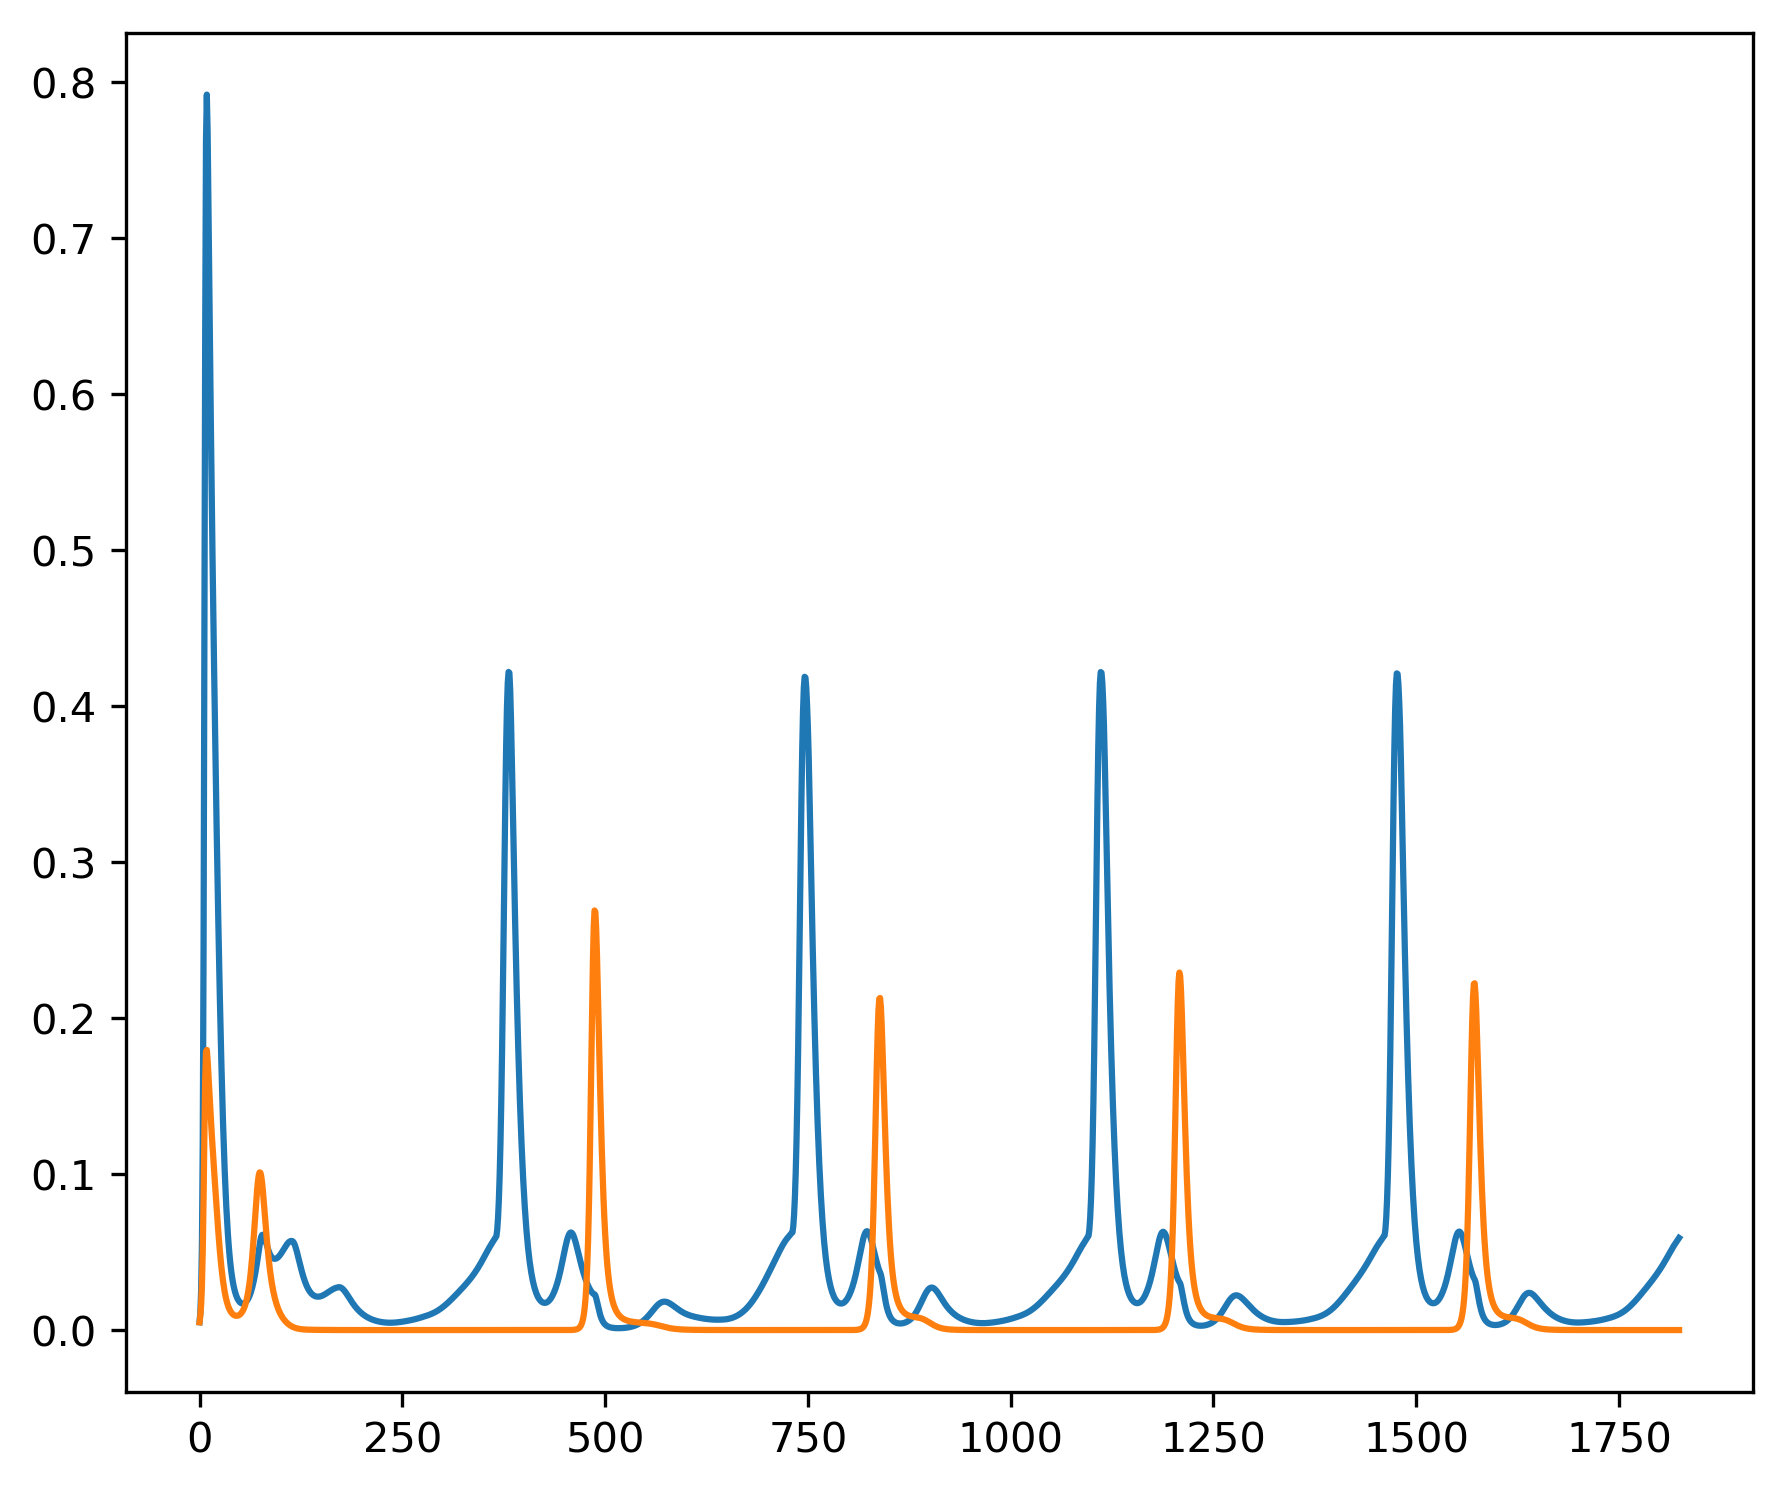

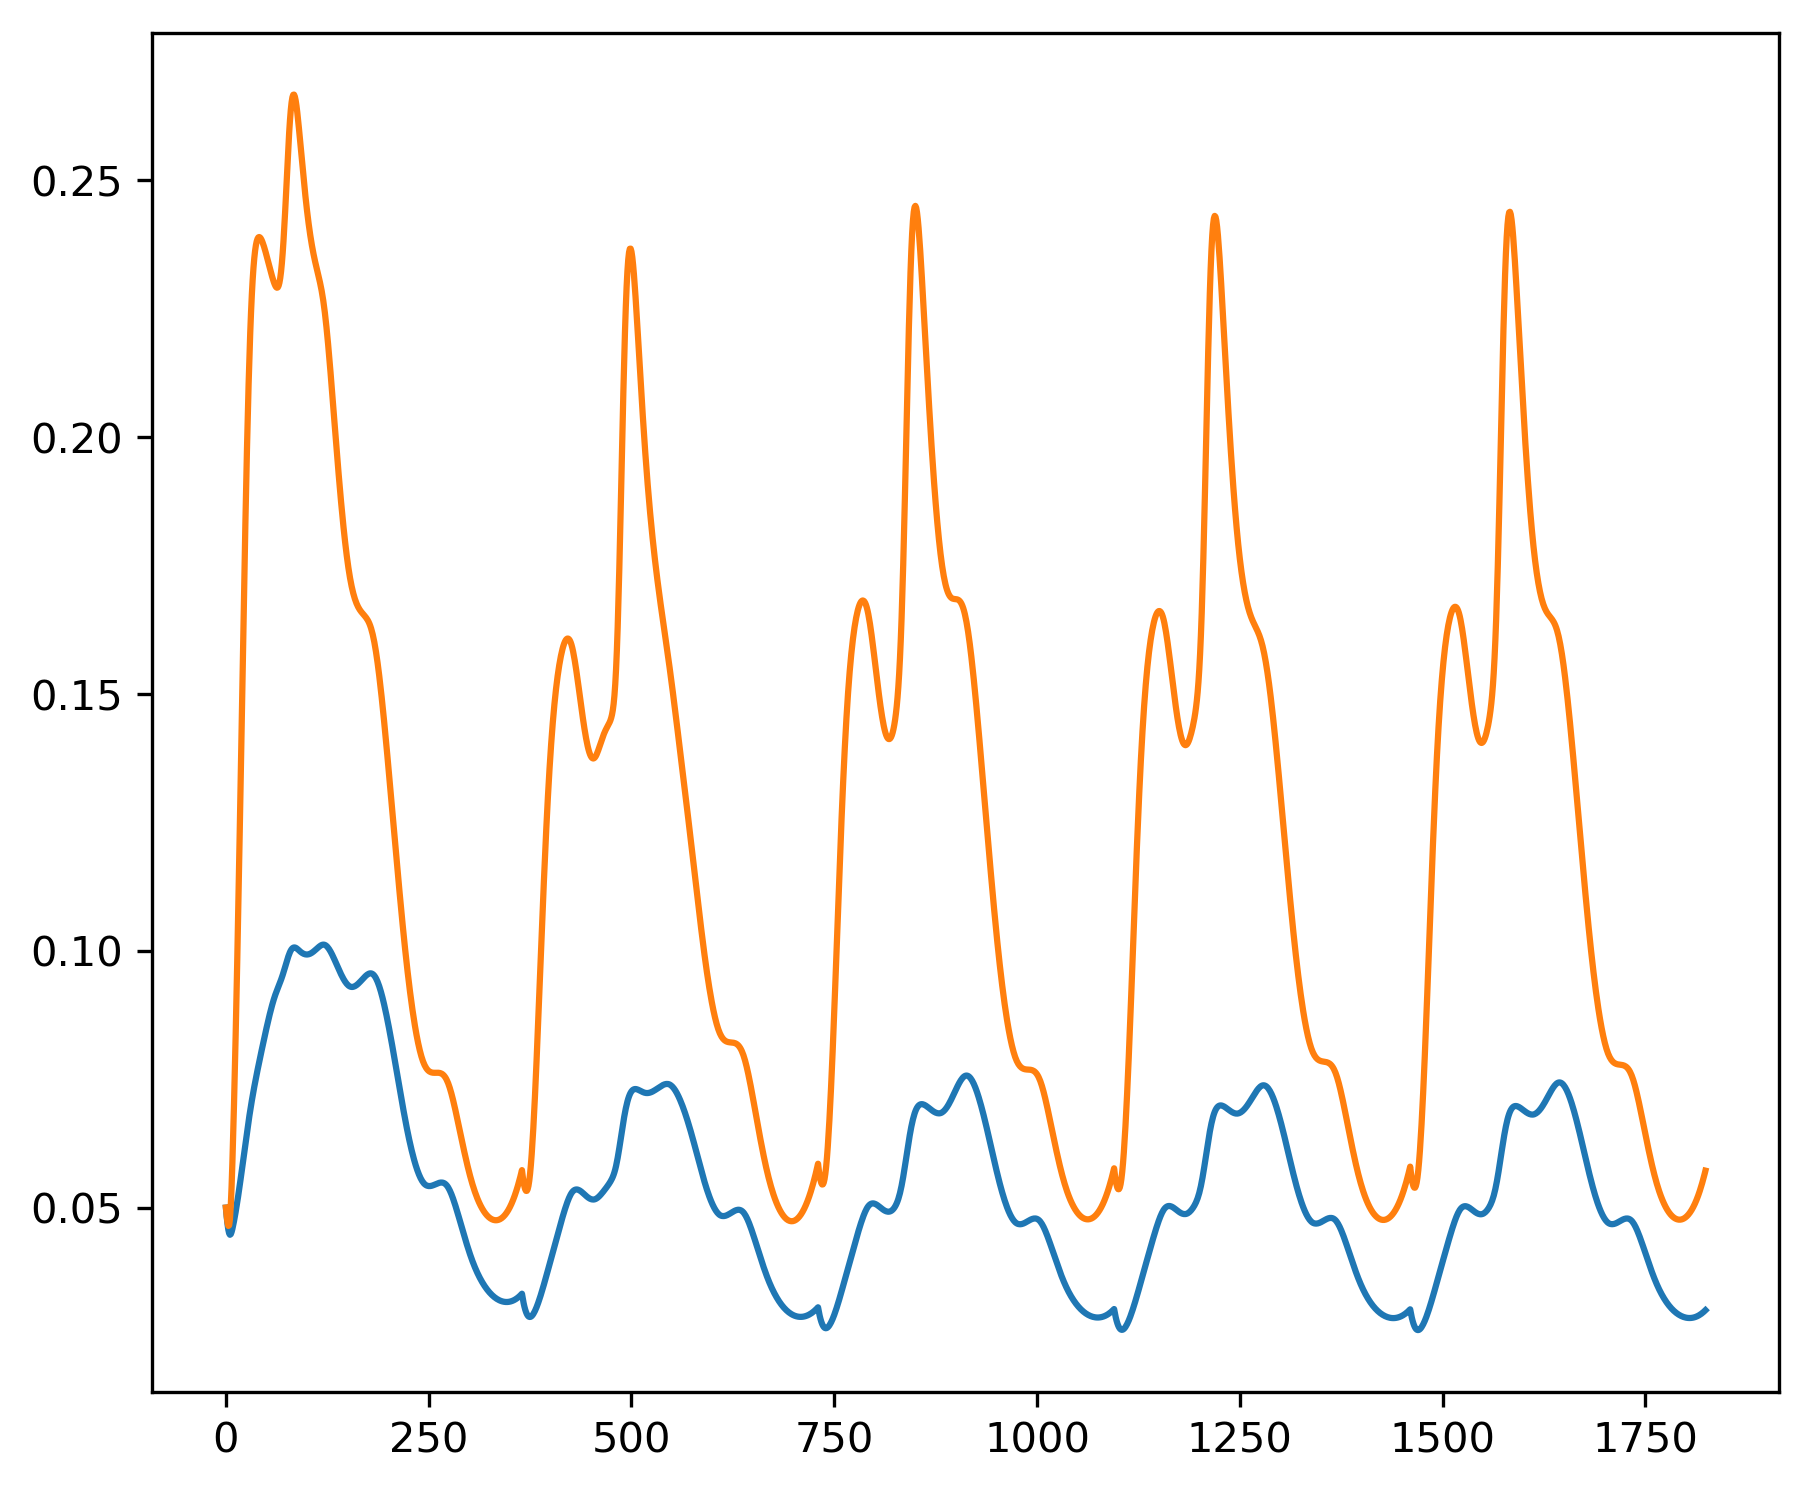

In [68]:
print(outarray) #[y0, y1, y2] + zoo + phy
a = [plt.plot(outarray[:,3+zn+i]) for i in range(pfn)]
print(pfn)
plt.show()

b = [plt.plot(outarray[:,3+i]) for i in range(zn)]
plt.show()

# do the fitting

In [19]:
# fit model
result = minimize(residual, all_params, args=(), method='differential_evolution')  # leastsq nelder
# check results of the fit
outarray = g(initcond, timedays_model, result.params)
print(result.aic)

NameError: name 'residual' is not defined

In [ ]:
report_fit(result)
print(result.residual)

In [69]:
timedays = timedays_model[1:366]
#truncate outarraySiNO to last year of 5:
outarray_ly = outarray[1460:1825]

# plot results

In [76]:
# color vectors
colors = ['#00C90D', '#01939A', '#d16f00', '#d13700', '#d10000']
alphas = [1., 0.8, 0.6, 0.4]
lws = [1, 2.5, 4, 5.5]

# artist for legends
FullArtist = plt.Line2D((0, 1), (0, 0), c=colors[4], alpha=alphas[1], lw=lws[0])

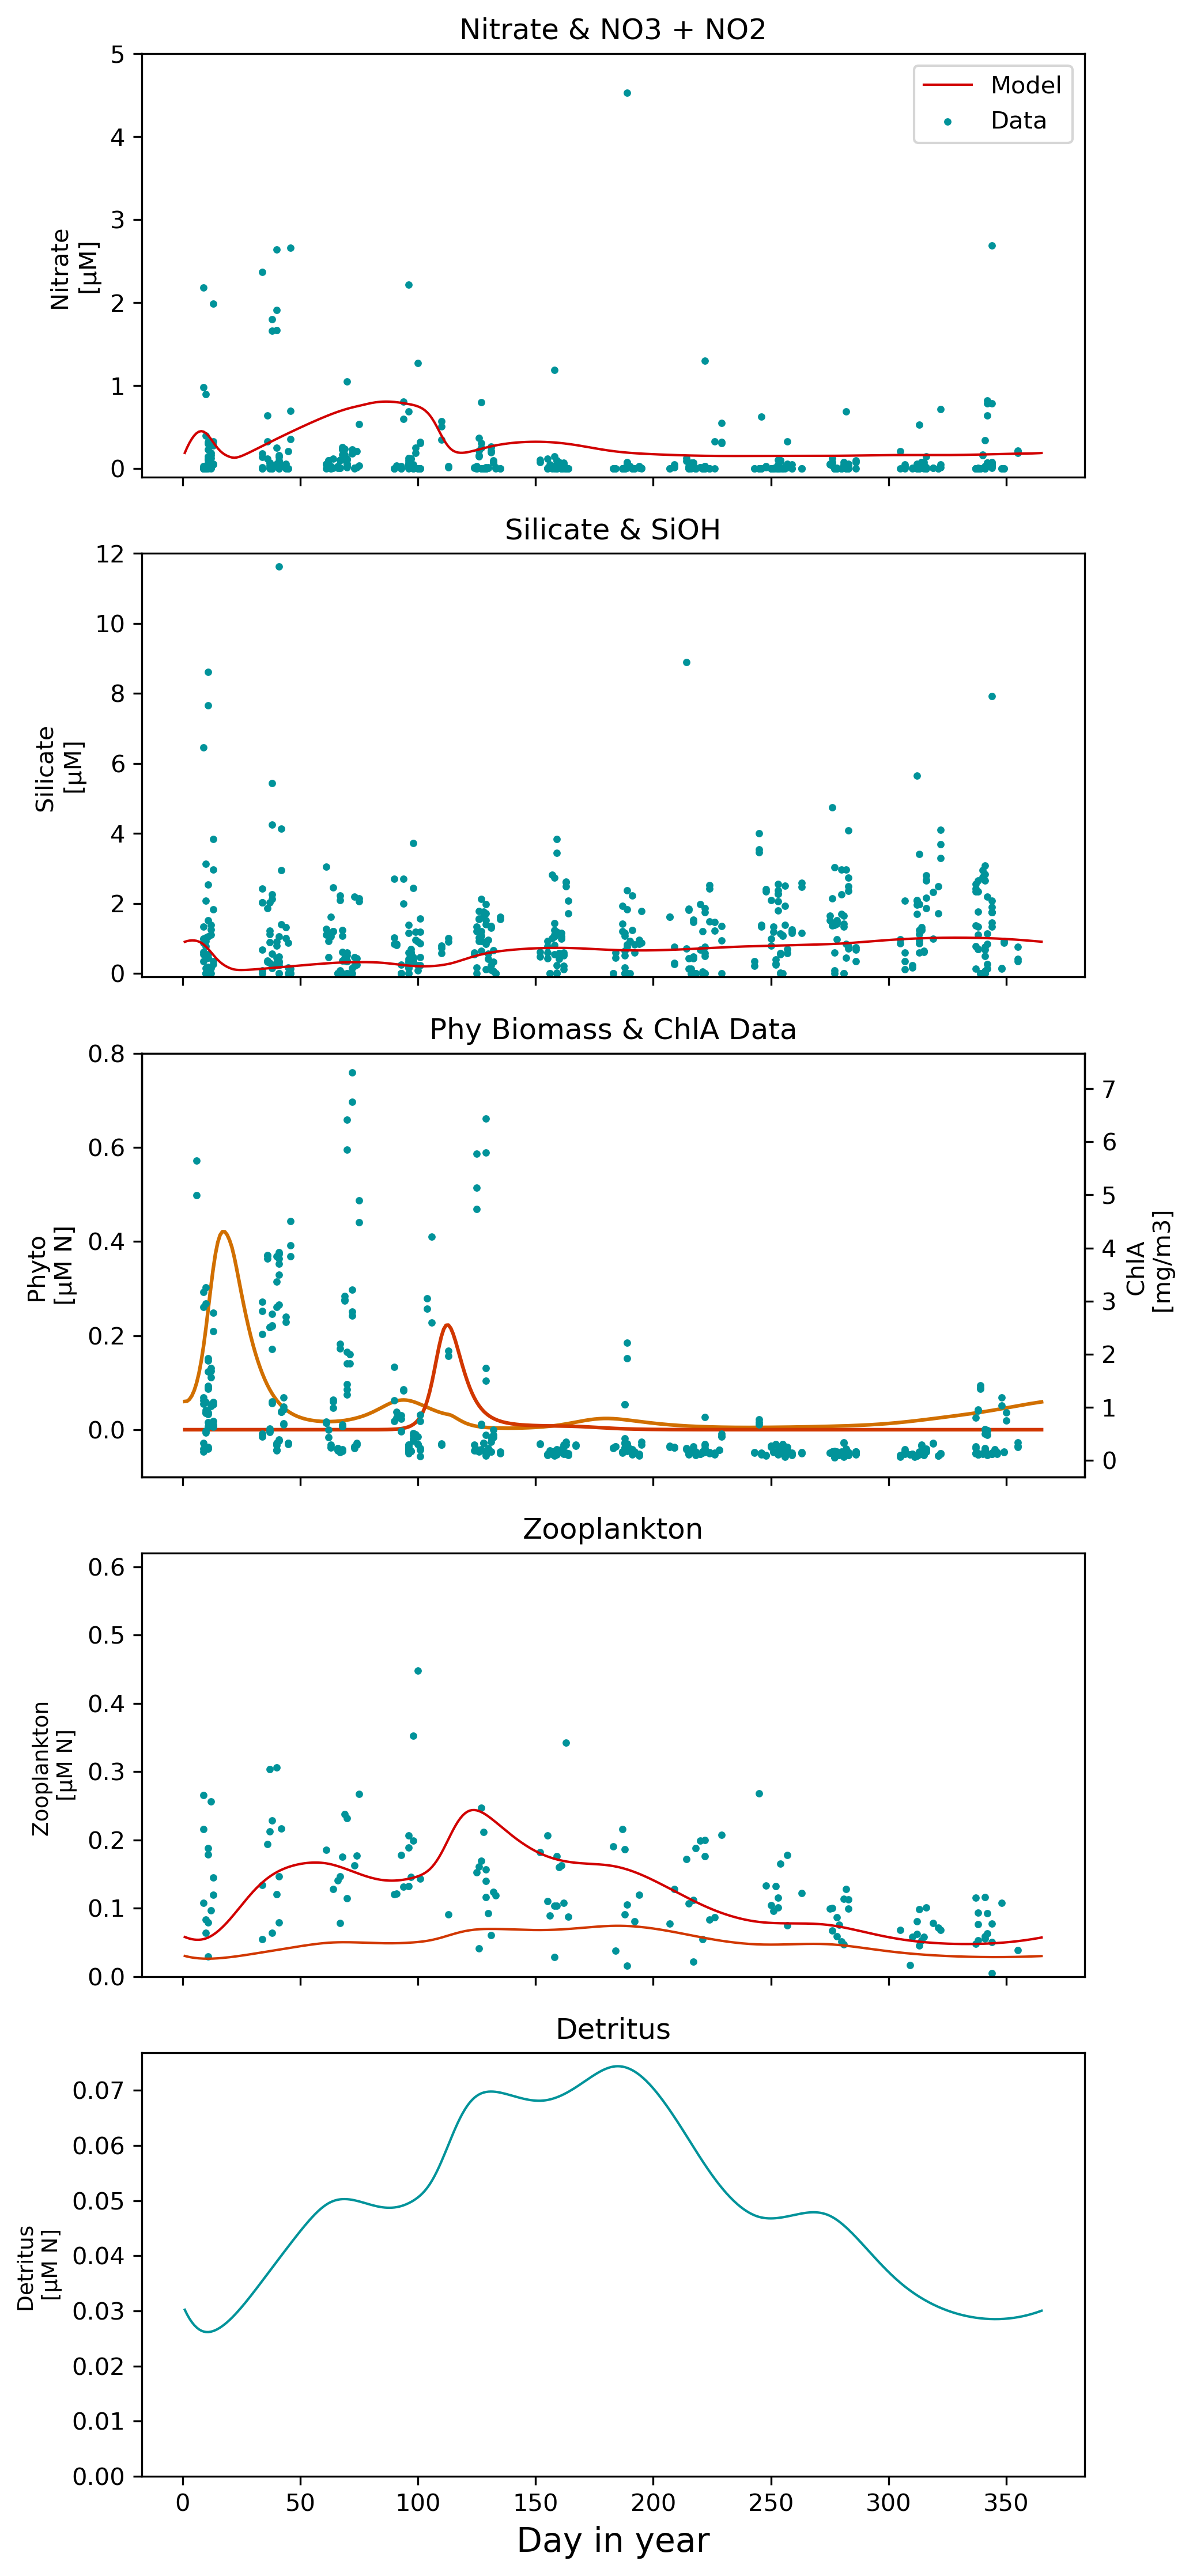

In [78]:
# Figure 1
f1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex='col', sharey='row')
# N
ax1.plot(timedays, outarray_ly[:, 0], c=colors[4], lw=lws[0], alpha=alphas[0], label='Model')
ax1.set_ylabel('Nitrate \n' '[µM]', multialignment='center', fontsize=10)
ax1.set_ylim(-0.1, 5)

# N Data
ax1.scatter(NO3NO2['yday'].values, NO3NO2['NO3NO2'].values, c=colors[1],s=4.3, label='Data')
ax1.set_title('Nitrate & NO3 + NO2')
ax1.legend(loc=1)

# Si
ax2.plot(timedays, outarray_ly[:, 1], c=colors[4], lw=lws[0], alpha=alphas[0])
ax2.set_ylabel('Silicate \n' '[µM]', multialignment='center', fontsize=10)
ax2.set_ylim(-0.1, 12)
# Si Data
ax2.scatter(SiOH_USF['yday'].values, SiOH_USF['SiOH'].values, c=colors[1],s=4.3)
ax2.set_title('Silicate & SiOH')

#Phyto
[ax3.plot(timedays, outarray_ly[:, 3+zn+i], c=colors[i+2]) for i in range(pfn)]
ax3.set_ylabel('Phyto \n' '[µM N]', multialignment='center', fontsize=10)
ax3.set_ylim(-0.1, 0.8)
# Phyto Data
ax3_tx = ax3.twinx()
ax3_tx.scatter(ChlA['yday'].values, ChlA['ChlA'].values, c=colors[1],s=4.3)
ax3_tx.set_ylabel('ChlA \n [mg/m3]')

ax3.set_title('Phy Biomass & ChlA Data')

# Z
[ax4.plot(timedays, outarray_ly[:, 3+i], c=colors[i+3], lw=lws[0], alpha=alphas[0]) for i in range(pfn)]
ax4.set_ylabel('Zooplankton \n' '[µM N]', multialignment='center', fontsize=9)
ax4.tick_params('y', labelsize=10)

ax4.scatter(ZooBM['yday'].values, ZooBM['ZooBM'].values*0.1*0.071394, c=colors[1],s=4.3)
# 10% N of dry weight assumed, converted to µM

ax4.set_title('Zooplankton')
ax4.set_ylim(0, 0.62)

# D
ax5.plot(timedays, outarray_ly[:, 3], c=colors[1], lw=lws[0], alpha=alphas[0])
ax5.set_ylabel('Detritus \n' '[µM N]', multialignment='center', fontsize=9)

ax5.set_title('Detritus')
ax5.set_ylim(bottom=0)

ax5.set_xlabel('Day in year', fontsize=14)
# Legend


#plt.subplots_adjust(hspace=0.01)
f1.set_figheight(15)
plt.tight_layout()
plt.show()